In [1]:
# conda install -c conda-forge fbprophet 

In [2]:
# !pip install boto3

In [3]:
import boto3
import pandas as pd
import io
client = boto3.client('s3', aws_access_key_id='XXXXXXXXX', 
                            aws_secret_access_key='XXXXXXX)
bucket = 'XXXX'
object_key = 'state_kerala_covid_cases.csv'
csv_obj = client.get_object(Bucket=bucket, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_data = pd.read_csv(io.StringIO(csv_string),
                      usecols=lambda column : column not in ["Sno"],
#                       index_col=[0],
                      header = 0,
#                       date_parser= pd.to_datetime,
#                       infer_datetime_format=True,
                      low_memory=False, sep=",")

In [4]:
df_data.head()

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [5]:
df_data.Date = pd.to_datetime(df_data.Date,dayfirst=True)

In [6]:
df_data.set_index('Date',inplace=True)
df_data.head()

,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Date,,,,,,,
2020-01-30,6:00 PM,Kerala,1,0,0,0,1
2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2020-02-01,6:00 PM,Kerala,2,0,0,0,2
2020-02-02,6:00 PM,Kerala,3,0,0,0,3
2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2020-01-30 to 2020-04-27
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Time                      89 non-null     object
 1   State/UnionTerritory      89 non-null     object
 2   ConfirmedIndianNational   89 non-null     object
 3   ConfirmedForeignNational  89 non-null     object
 4   Cured                     89 non-null     int64 
 5   Deaths                    89 non-null     int64 
 6   Confirmed                 89 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 5.6+ KB


In [8]:
df_train = df_data[: -10]
df_test = df_data[-10 : ]

In [59]:
import numpy as np
df_pr_train = pd.DataFrame()
df_pr_test = pd.DataFrame()
# df_pr_train['ds'] = pd.to_datetime(df_train.index)
# df_pr_train['y'] = np.log(df_train.Confirmed.values)
# df_pr_test['ds'] = pd.to_datetime(df_test.index)
# df_pr_test['y'] = np.log(df_test.Confirmed.values)
df_pr_train['ds'] = pd.to_datetime(df_train.index)
df_pr_train['y'] = df_train.Confirmed.values
df_pr_test['ds'] = pd.to_datetime(df_test.index)
df_pr_test['y'] = df_test.Confirmed.values

In [69]:
from sapdi import tracking
from fbprophet import Prophet
import time


run = tracking.start_run(run_collection_name='covid_forecasting')
start = time.time()

prophet_basic = Prophet()
prophet_basic.fit(df_pr_train) 
print('FBProphet Model Training Completed in {} seconds'.format(time.time()-start))

# tracking.log_metric('RMSE' , RMSE )
tracking.set_tags({
    "model" : "FBProphet"
})
tracking.end_run() 

29-Apr-20 09:52:12(fbprophet)(INFO):Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
29-Apr-20 09:52:12(fbprophet)(INFO):Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FBProphet Model Training Completed in 1.2264389991760254 seconds


In [70]:
future= prophet_basic.make_future_dataframe(periods=30,freq='D',include_history = True )

In [71]:
start = time.time()
forecast = prophet_basic.predict(future)
print('FBProphet Model prediction Completed in {} seconds'.format(time.time()-start))

FBProphet Model prediction Completed in 3.4251208305358887 seconds


In [72]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
104,2020-05-13,798.030256,752.573133,840.782708,759.216998,838.279395,-0.580064,-0.580064,-0.580064,-0.580064,-0.580064,-0.580064,0.0,0.0,0.0,797.450192
105,2020-05-14,811.812746,762.964852,855.131128,770.447022,854.515419,-2.168580,-2.168580,-2.168580,-2.168580,-2.168580,-2.168580,0.0,0.0,0.0,809.644166
106,2020-05-15,825.595235,773.573398,870.026981,782.153162,870.440904,-2.445903,-2.445903,-2.445903,-2.445903,-2.445903,-2.445903,0.0,0.0,0.0,823.149332
107,2020-05-16,839.377724,792.873492,895.123543,793.660633,886.927149,2.343855,2.343855,2.343855,2.343855,2.343855,2.343855,0.0,0.0,0.0,841.721579
108,2020-05-17,853.160214,803.129315,909.141661,804.769332,903.504013,1.442143,1.442143,1.442143,1.442143,1.442143,1.442143,0.0,0.0,0.0,854.602357


In [73]:
# forecast.set_index('ds',inplace=True)
# forecast.head()

In [74]:
# actual_predicted_test_df = df_test.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'inner')

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# actual_predicted_test_df['yhat_predicted'] = np.expm1(actual_predicted_test_df.yhat)
# actual_predicted_test_df['yhat_lower_predicted'] = np.expm1(actual_predicted_test_df.yhat_lower)
# actual_predicted_test_df['yhat_upper_predicted'] = np.expm1(actual_predicted_test_df.yhat_upper)

In [76]:
df_compare = pd.DataFrame()
df_compare['ds'] = pd.to_datetime(list(df_data.index))
df_compare['y'] = df_data.Confirmed.values

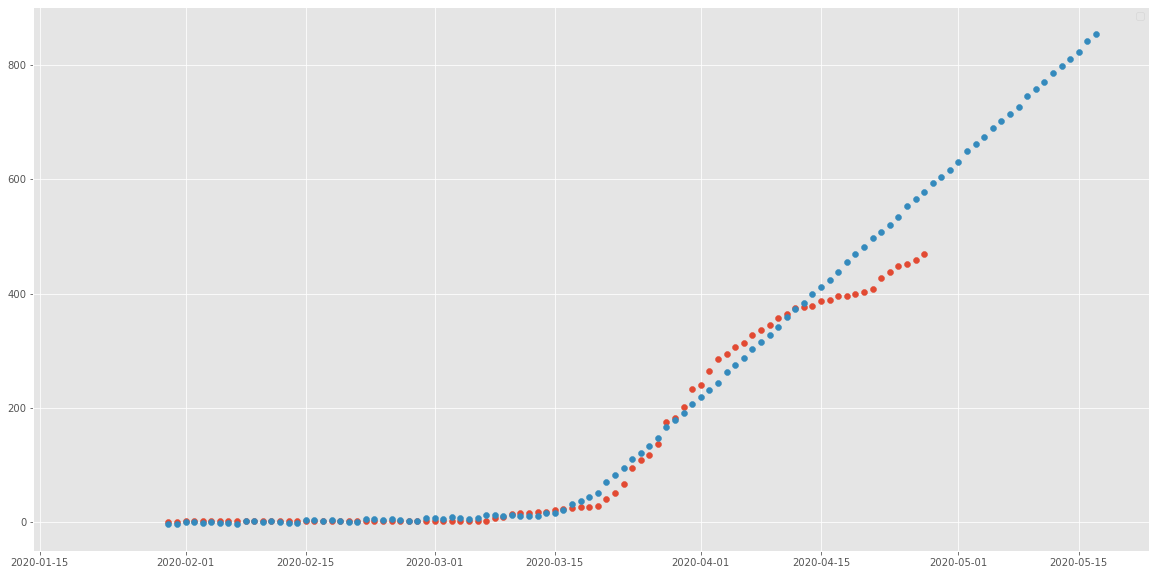

In [79]:
fig, ax = plt.subplots()
ax.scatter(df_compare['ds'], df_compare['y'])
ax.scatter(forecast['ds'],forecast['yhat'])
ax.legend()
plt.show()

In [82]:
df_mh

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,0009-03-20,6:00 PM,Maharashtra,2,0,0,0,2
1,0010-03-20,6:00 PM,Maharashtra,5,0,0,0,5
2,0011-03-20,6:00 PM,Maharashtra,2,0,0,0,2
3,0012-03-20,6:00 PM,Maharashtra,11,0,0,0,11
4,0013-03-20,6:00 PM,Maharashtra,14,0,0,0,14
5,0014-03-20,6:00 PM,Maharashtra,14,0,0,0,14
6,0015-03-20,6:00 PM,Maharashtra,32,0,0,0,32
7,0016-03-20,6:00 PM,Maharashtra,32,0,0,0,32
8,0017-03-20,6:00 PM,Maharashtra,36,3,0,1,39
9,0018-03-20,6:00 PM,Maharashtra,39,3,0,1,42
